In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
from torch.utils.data import DataLoader


In [21]:
transforms=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [22]:
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [23]:
class CIFAR_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layer=nn.Sequential(
        nn.Conv2d(3,32,3,1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(32,64,3,1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(64,64,3,1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )

    self._to_linear=None
    self._get_flatten_size()

    self.fc_layer=nn.Sequential(
        nn.Linear(self._to_linear,256),
        nn.ReLU(),
        nn.Linear(256,10)
    )

  def _get_flatten_size(self):
    x=torch.randn(1,3,32,32)
    x=self.conv_layer(x)
    self._to_linear=x.numel()
  def forward(self,x):
    if self.conv_layer is None:
      raise Exception("conv_layer is not initialized")
    x=self.conv_layer(x)
    x=x.view(x.size(0),-1)
    x=self.fc_layer(x)
    return x







In [24]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
model=CIFAR_CNN().to(device)

In [26]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [18]:
epochs=2
for epoch in range(epochs):
  model.train()
  running_loss=0
  correct=0
  total=0
  for images,labels in train_loader:
    images,labels = images.to(device),labels.to(device)
    outputs=model(images)
    loss=criterion(outputs,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss=loss.item()
    _,predicted=torch.max(outputs,1)
    total +=labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.3f}- Accuracy:{100*correct/total:.2f}%")

Epoch [2/2], Loss: 0.001- Accuracy:76.39%


In [34]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())  # extend, not append
        all_labels.extend(labels.cpu().numpy())




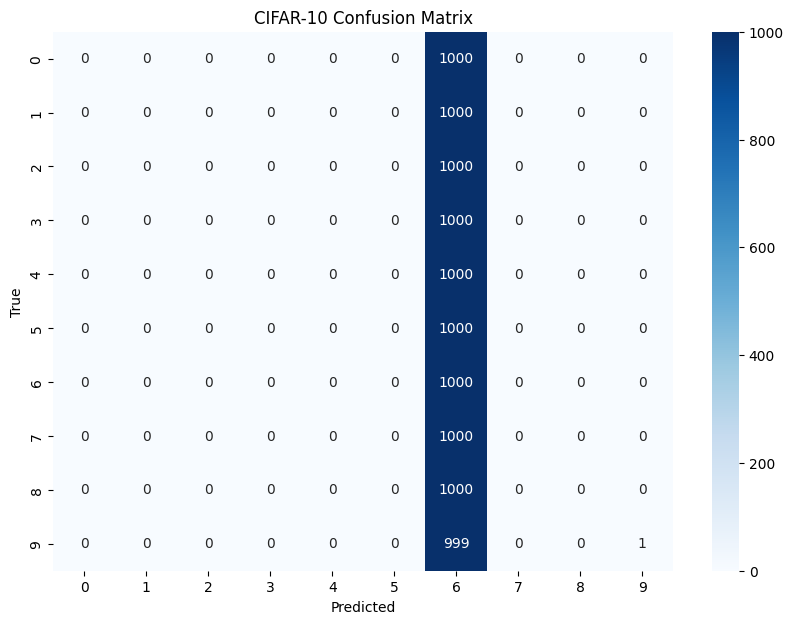

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1000
           1     0.0000    0.0000    0.0000      1000
           2     0.0000    0.0000    0.0000      1000
           3     0.0000    0.0000    0.0000      1000
           4     0.0000    0.0000    0.0000      1000
           5     0.0000    0.0000    0.0000      1000
           6     0.1000    1.0000    0.1818      1000
           7     0.0000    0.0000    0.0000      1000
           8     0.0000    0.0000    0.0000      1000
           9     1.0000    0.0010    0.0020      1000

    accuracy                         0.1001     10000
   macro avg     0.1100    0.1001    0.0184     10000
weighted avg     0.1100    0.1001    0.0184     10000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [35]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CIFAR-10 Confusion Matrix")
plt.show()

# Metrics
print(classification_report(all_labels, all_preds, digits=4))
